In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely import geometry
from shapely import wkt
from libpysal.weights import contiguity
from libpysal.weights import lag_spatial
from pyproj import CRS
import mapclassify as mc
import splot
import esda
import seaborn as sns
from esda.moran import Moran
from splot.esda import moran_scatterplot
from splot.esda import plot_moran
import matplotlib.pyplot as plt
import gc
from esda.moran import Moran_Local
from splot.esda import lisa_cluster
from splot.esda import plot_local_autocorrelation
from splot.libpysal import plot_spatial_weights
from esda.moran import Moran_BV_matrix
from splot.esda import moran_facet
from shapely.ops import cascaded_union
from geovoronoi.plotting import subplot_for_map, plot_voronoi_polys_with_points_in_area
from geovoronoi import voronoi_regions_from_coords, points_to_coords

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
%config Completer.use_jedi = False

In [2]:
def load_shp_from_csv(name:str):
    df = pd.read_csv(f'../datasets/preprocessed_data/{name}.csv')
    df['geometry'] = df['geometry'].apply(wkt.loads)
    df = gpd.GeoDataFrame(df, crs='epsg:4258')
    return df

In [3]:
df_warszawa = load_shp_from_csv("df_warszawa")
df_krakow = load_shp_from_csv("df_krakow")
df_poznan = load_shp_from_csv("df_poznan")

pov = gpd.read_file("../datasets/raw_data/guigk_pov/Powiaty.shx", encoding='utf-8')
pov = pov.loc[pov.JPT_NAZWA_.isin(["powiat Warszawa", "powiat Kraków", "powiat Poznań"])==True, ("JPT_NAZWA_", "geometry")]
pov = pov.to_crs("epsg:4258")

print(df_warszawa.shape, df_krakow.shape, df_poznan.shape)

(601, 32) (396, 32) (324, 32)


# Spatial SEDA

In [4]:
def spatial_seda(city, city_name, analysis_part):    
    df = city.copy()
    df_facet = df[['poczta', 'dhl', 'inpost', 'dpd', 'ruch']]
    
    # spatial weight matrix
    y = df.inpost.values
    w = contiguity.Queen.from_dataframe(df)
    w.transform = 'r'
    if analysis_part == 1:
        plot_spatial_weights(w, df["geometry"].to_crs("epsg:3395"))
        plt.title("Spatial weights visualization")
        plt.show()

        #general plot, quantiles plot, spatial lag plot
        fig, axs = plt.subplots(1, 3, figsize=(30,10))

        df.plot(column="inpost", legend=True, figsize=(10,10), ax=axs[0])
        axs[0].set_title("InPost")
        axs[0].legend(prop={'size': 2})

        df.plot(column='inpost', scheme='Quantiles', k=5, legend=True, figsize=(10,10), ax=axs[1])
        axs[1].set_title("InPost (Quintiles)")

        ylag = lag_spatial(w, y)
        ylagq5 = mc.Quantiles(ylag, k=4)

        df.assign(cl=ylagq5.yb).plot(column='cl', categorical=True, k=4, linewidth=0.1, ax=axs[2], legend=True, cmap="viridis")
        axs[2].set_title("Spatial Lag InPost (Quintiles)")
        plt.show()
    elif analysis_part == 2:
        #moran global
        mi = esda.moran.Moran(y, w)
        print("Moran's I", mi.I, "\np-value of I under normality assumption", mi.p_norm, "\np-value based on permutations", mi.p_sim)
        plot_moran(mi, zstandard=True, figsize=(10,4))
        plt.show()

        #geary global
        geary = esda.geary.Geary(y, w)
        print("Geary's: ", geary.C, "p-value:", geary.p_sim)

        # joint count global
        y_prim = (y > np.quantile(y, 0.85)) * 1
        df["inpost_bin"] = y_prim
        df.plot(column="inpost_bin", legend=True, figsize=(10,10))
        plt.title("InPost in Joint Count analysis")
        plt.show()
        w.transform = 'O'
        jc = esda.join_counts.Join_Counts(df.inpost_bin, w)
        print("Joint count bb pvalue", jc.p_sim_bb, ";JC bw pvalue", jc.p_sim_bw)
        w.transform = 'R'
    elif analysis_part == 3:
        #moran local
        moran_loc = Moran_Local(y, w)
        fig, ax = moran_scatterplot(moran_loc, p=0.1)
        ax.set_xlabel('InPost')
        ax.set_ylabel('Spatial Lag of InPost')
        plt.show()
        lisa_cluster(moran_loc, df.to_crs("epsg:3395"), p=0.1, figsize = (10, 10), legend=True, )
        plt.show()

        #moran bv analysis
        matrix2 = Moran_BV_matrix(df_facet, w)
        moran_facet(matrix2)
        plt.show()
        
    elif analysis_part == 4:
        #tessellation
        df_point = load_shp_from_csv("pickup_points_by_operator")
        df_point = df_point[df_point.operator=="inpost"]
        curr_pov = pov[pov.JPT_NAZWA_ == city_name]
        df_point = gpd.sjoin(df_point, curr_pov, op='within', how='inner').to_crs(epsg=3395)
        curr_pov = curr_pov.to_crs(epsg=3395)
        boundary_shape = cascaded_union(curr_pov.geometry)
        coords = points_to_coords(df_point.geometry)
        region_polys, region_pts = voronoi_regions_from_coords(coords, boundary_shape)

        fig, ax = subplot_for_map(figsize=(20,10))
        plot_voronoi_polys_with_points_in_area(ax, boundary_shape, region_polys, coords, region_pts)
        plt.show()

        fig, ax = subplot_for_map(figsize=(20,10))
        plot_voronoi_polys_with_points_in_area(ax, boundary_shape, region_polys, coords, points_markersize=0.1, voronoi_color='grey', voronoi_edgecolor='black')
        plt.show()

        df_point = load_shp_from_csv("pickup_points_by_operator")
        stats_per_operator = list()

        for operator in df_point.operator.unique():
            df_point_copy = df_point.copy()
            df_point_copy = df_point_copy[df_point_copy.operator==operator]
            curr_pov = pov[pov.JPT_NAZWA_ == city_name]
            df_point_copy = gpd.sjoin(df_point_copy, curr_pov, op='within', how='inner').to_crs(epsg=3395)
            curr_pov = curr_pov.to_crs(epsg=3395)
            boundary_shape = cascaded_union(curr_pov.geometry)
            coords = points_to_coords(df_point_copy.geometry)
            region_polys, region_pts = voronoi_regions_from_coords(coords, boundary_shape)
            a = np.array([region_polys[i].area for i in range(len(region_polys))])
            a1 = a/sum(a)
            ent1 = sum(-1*a1*np.log(a1))
            n = len(a)
            ent_ref = np.log(1/n)*(-1)
            ent_rel = ent1/ent_ref
            stats_per_operator.append([ent1, ent_rel])

        x = pd.DataFrame(stats_per_operator, index=df_point.operator.unique(), columns=["Shannon entropy", "Relative H entropy"])
        display(x)
        x["Relative H entropy"].plot(figsize=(10,5), title="Relative H entropy per operator")
        plt.show()

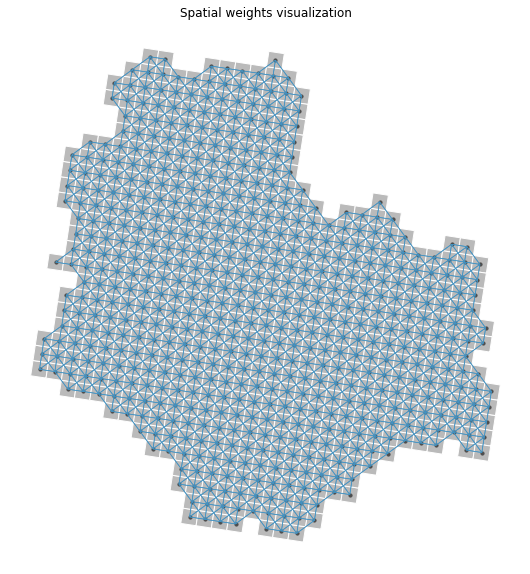

No handles with labels found to put in legend.
C:\Users\wozni\AppData\Local\Continuum\anaconda3\lib\site-packages\mapclassify\classifiers.py:235: UserWarning: Warning: Not enough unique values in array to form k classes
  "Warning: Not enough unique values in array to form k classes", UserWarning
C:\Users\wozni\AppData\Local\Continuum\anaconda3\lib\site-packages\mapclassify\classifiers.py:237: UserWarning: Warning: setting k to 4
  Warn("Warning: setting k to %d" % k_q, UserWarning)


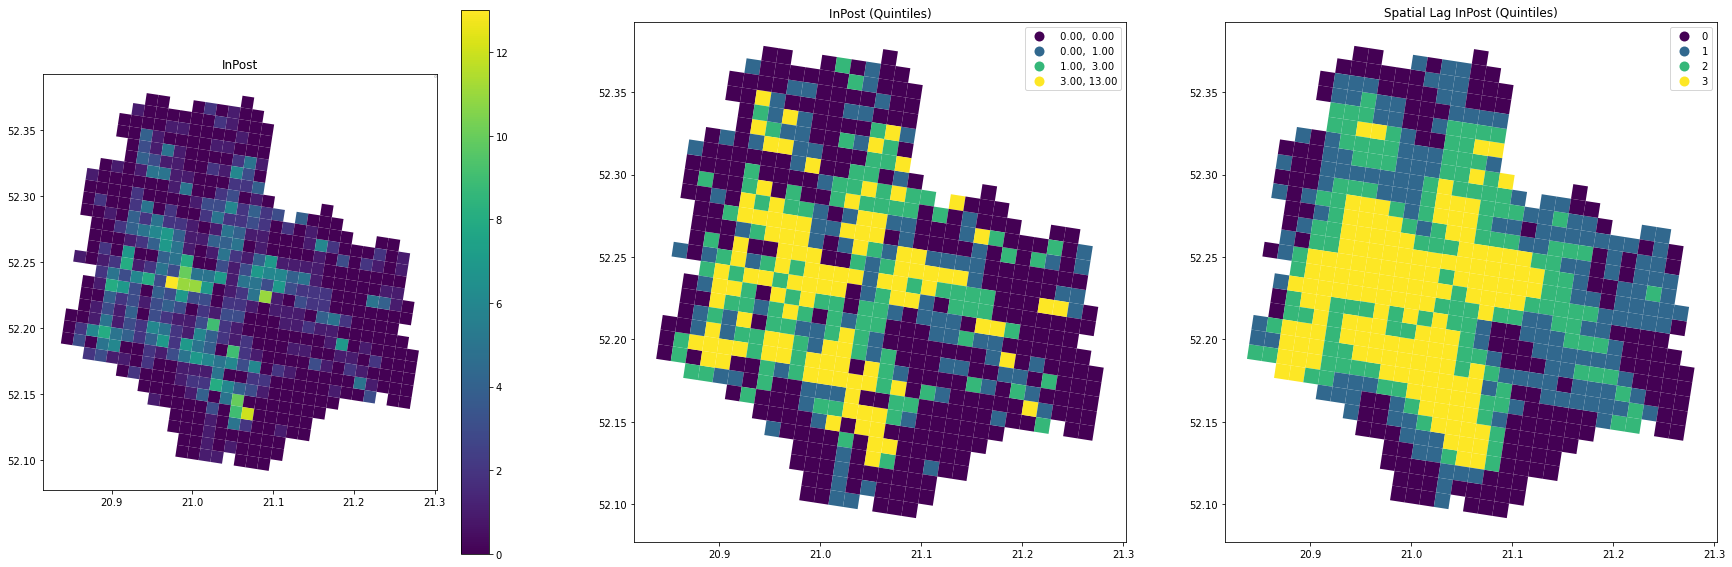

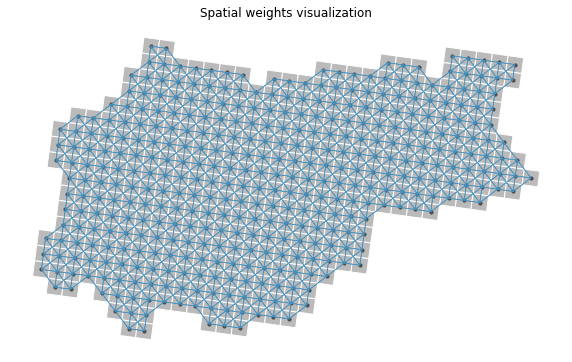

No handles with labels found to put in legend.
C:\Users\wozni\AppData\Local\Continuum\anaconda3\lib\site-packages\mapclassify\classifiers.py:235: UserWarning: Warning: Not enough unique values in array to form k classes
  "Warning: Not enough unique values in array to form k classes", UserWarning
C:\Users\wozni\AppData\Local\Continuum\anaconda3\lib\site-packages\mapclassify\classifiers.py:237: UserWarning: Warning: setting k to 3
  Warn("Warning: setting k to %d" % k_q, UserWarning)


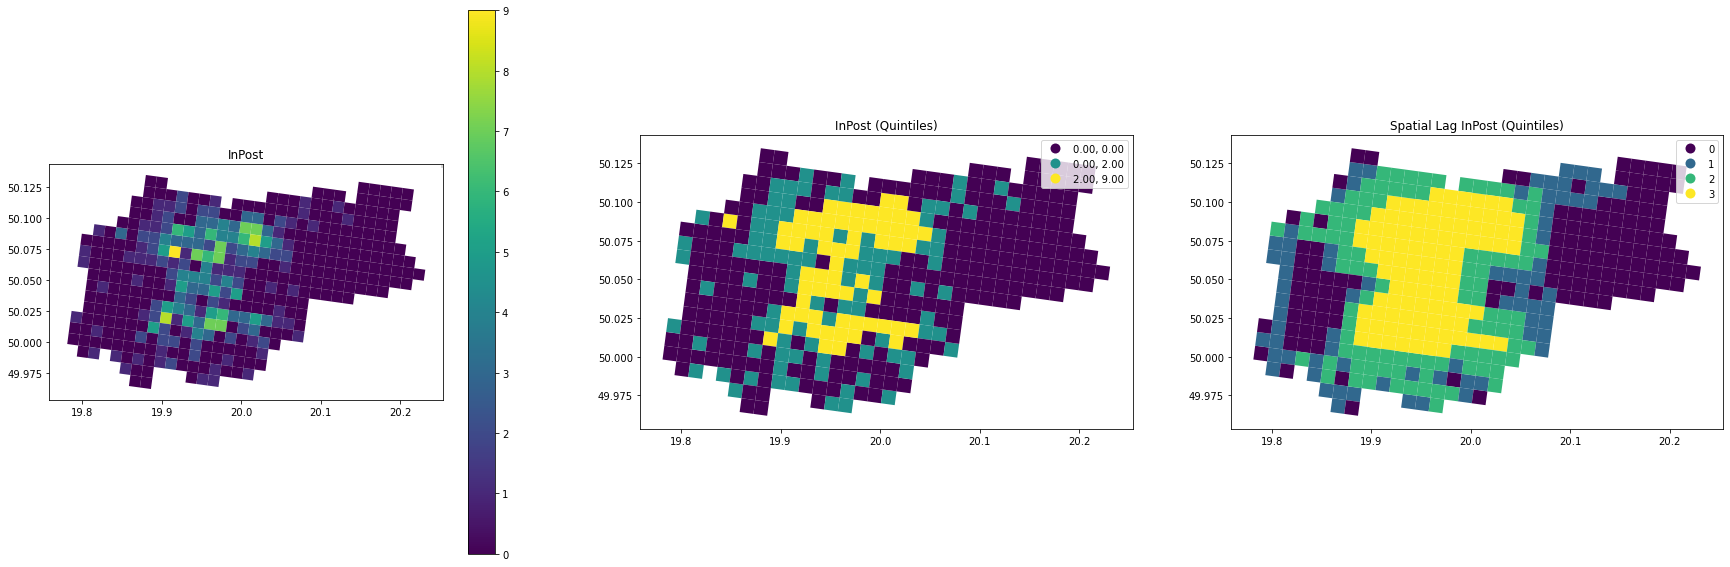

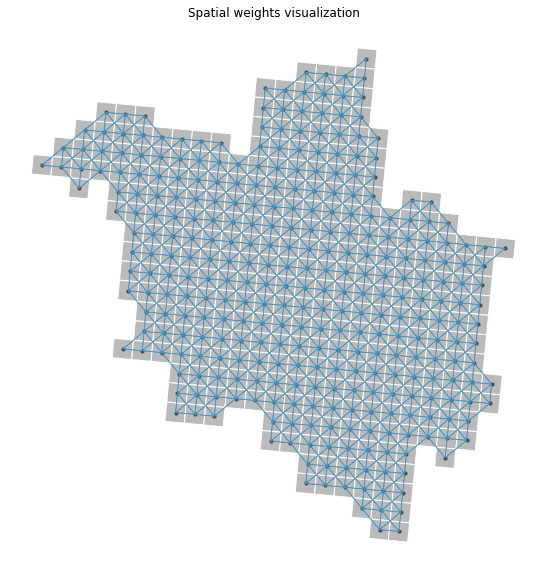

No handles with labels found to put in legend.
C:\Users\wozni\AppData\Local\Continuum\anaconda3\lib\site-packages\mapclassify\classifiers.py:235: UserWarning: Warning: Not enough unique values in array to form k classes
  "Warning: Not enough unique values in array to form k classes", UserWarning
C:\Users\wozni\AppData\Local\Continuum\anaconda3\lib\site-packages\mapclassify\classifiers.py:237: UserWarning: Warning: setting k to 4
  Warn("Warning: setting k to %d" % k_q, UserWarning)


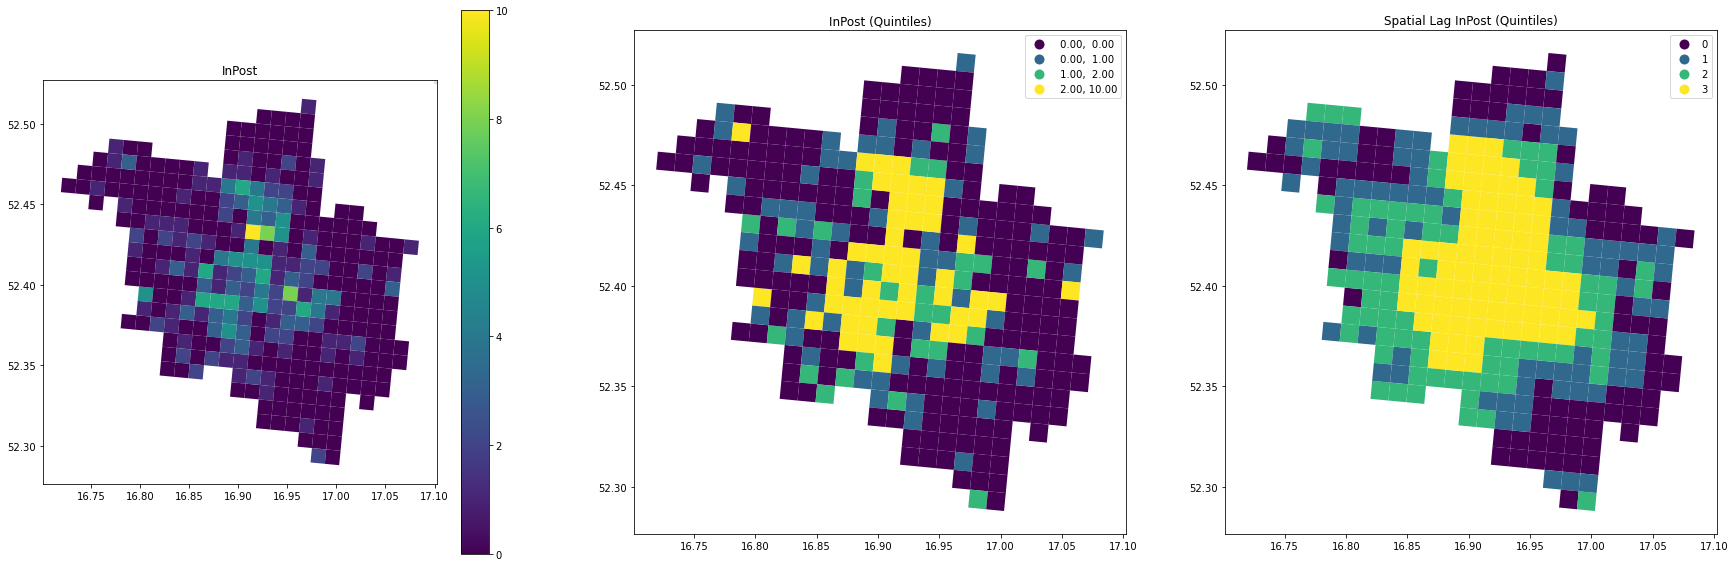

Moran's I 0.4020725532811403 
p-value of I under normality assumption 0.0 
p-value based on permutations 0.001


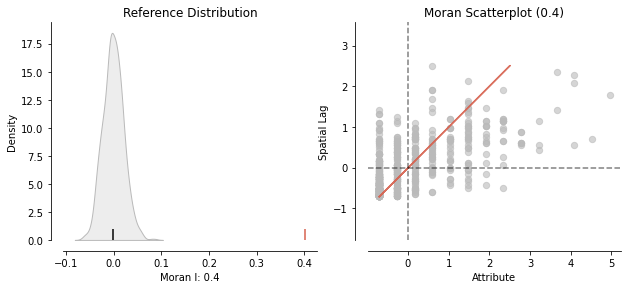

Geary's:  0.5984578850664994 p-value: 0.001


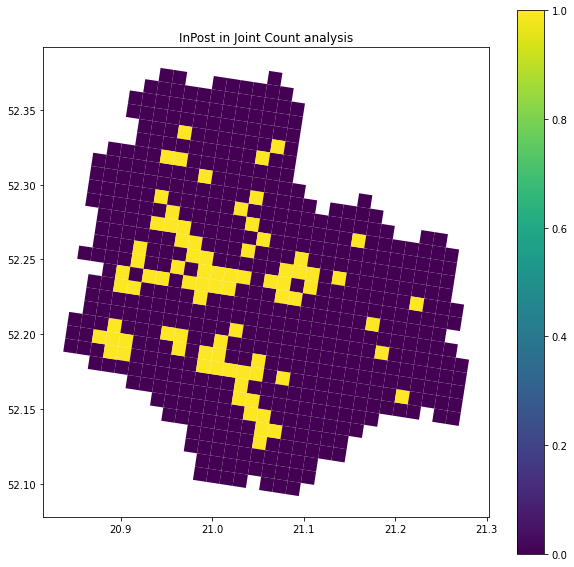

Joint count bb pvalue 0.001 ;JC bw pvalue 1.0
Moran's I 0.521756272206774 
p-value of I under normality assumption 0.0 
p-value based on permutations 0.001


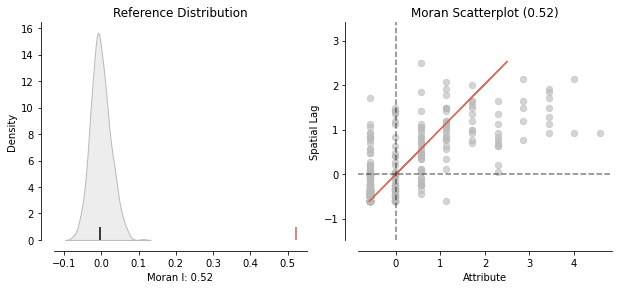

Geary's:  0.47879474971718783 p-value: 0.001


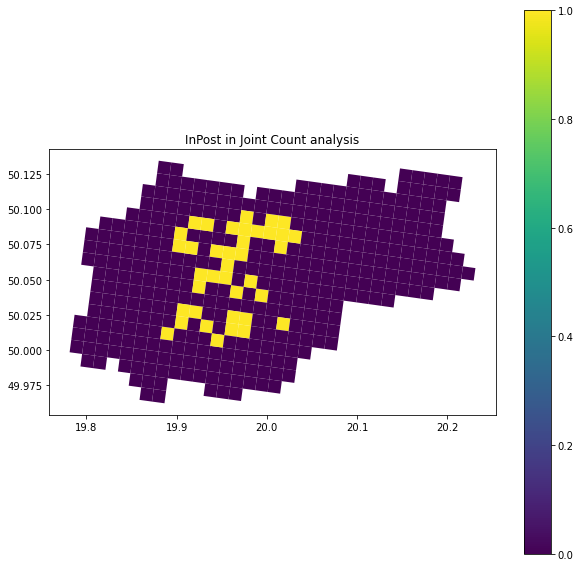

Joint count bb pvalue 0.001 ;JC bw pvalue 1.0
Moran's I 0.4081486700477835 
p-value of I under normality assumption 0.0 
p-value based on permutations 0.001


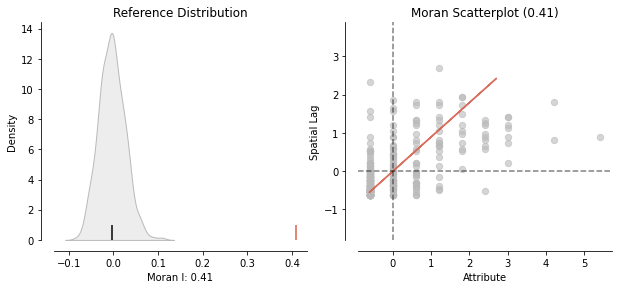

Geary's:  0.5912571695136601 p-value: 0.001


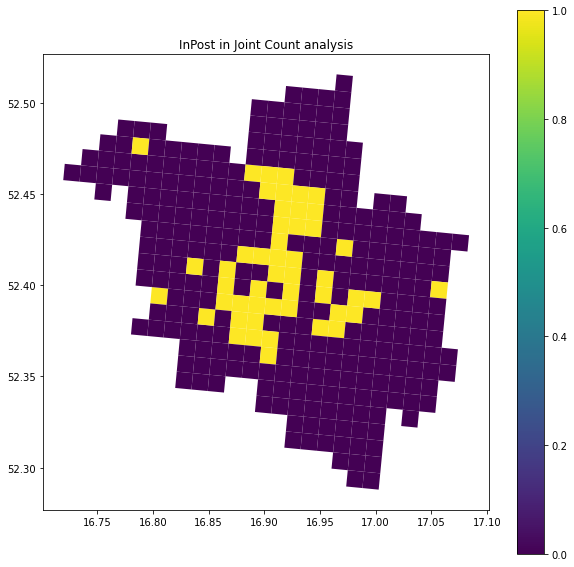

Joint count bb pvalue 0.001 ;JC bw pvalue 1.0


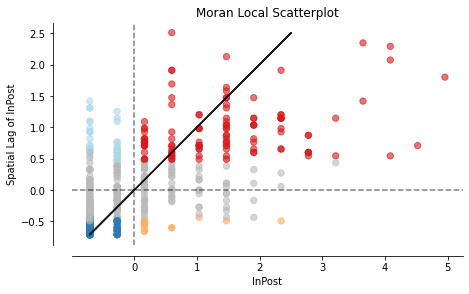

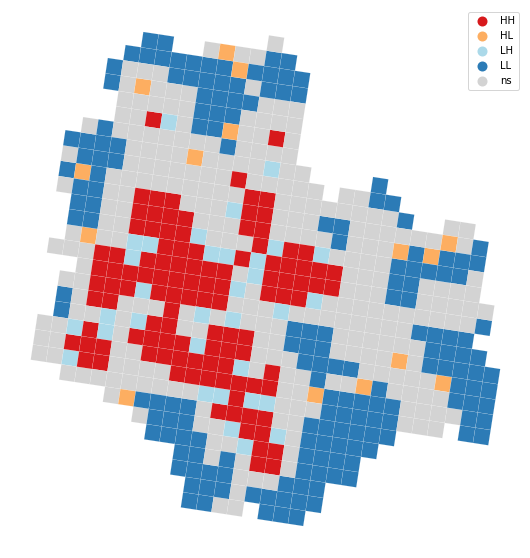

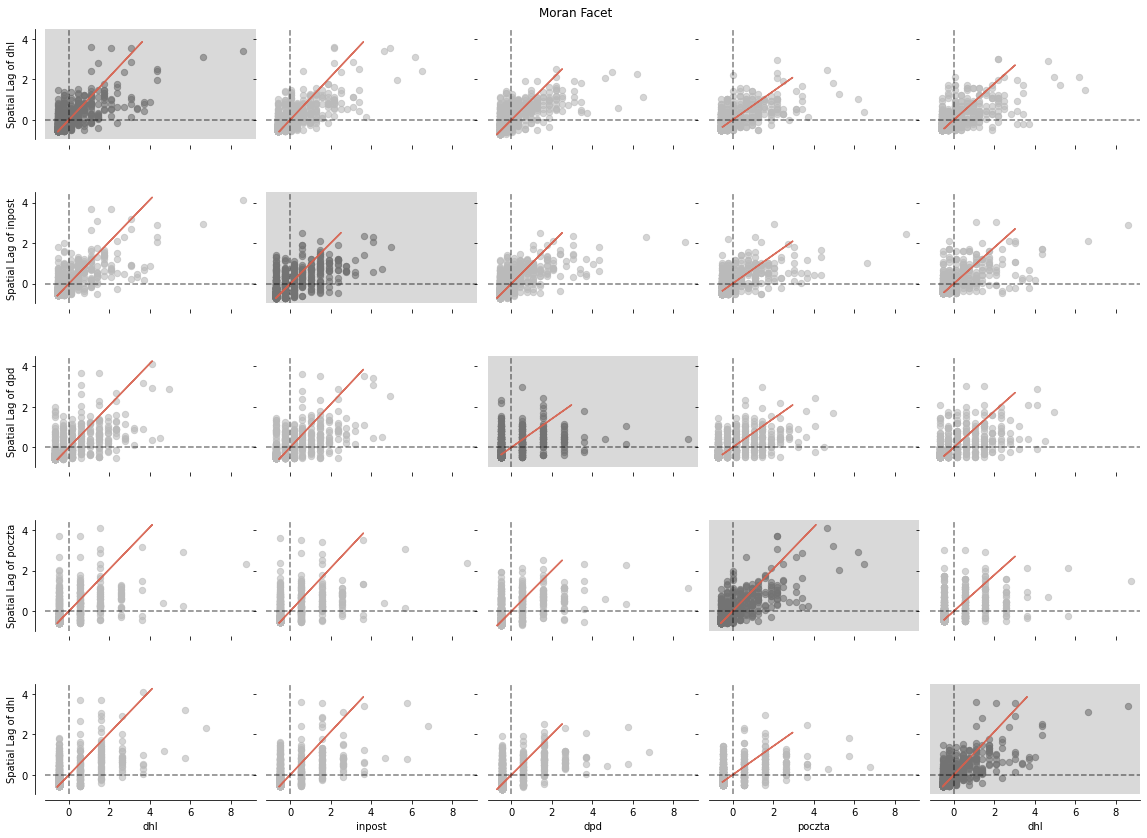

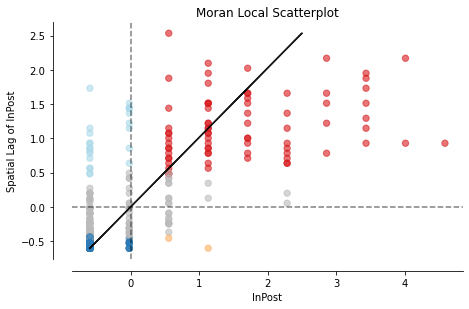

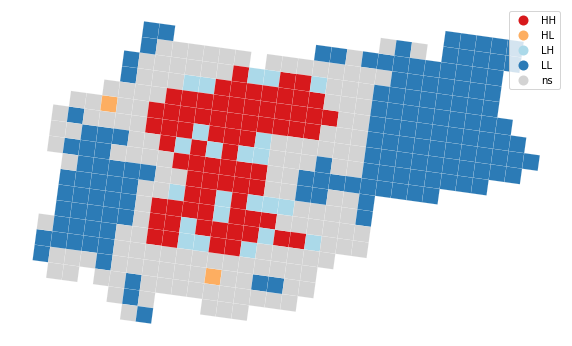

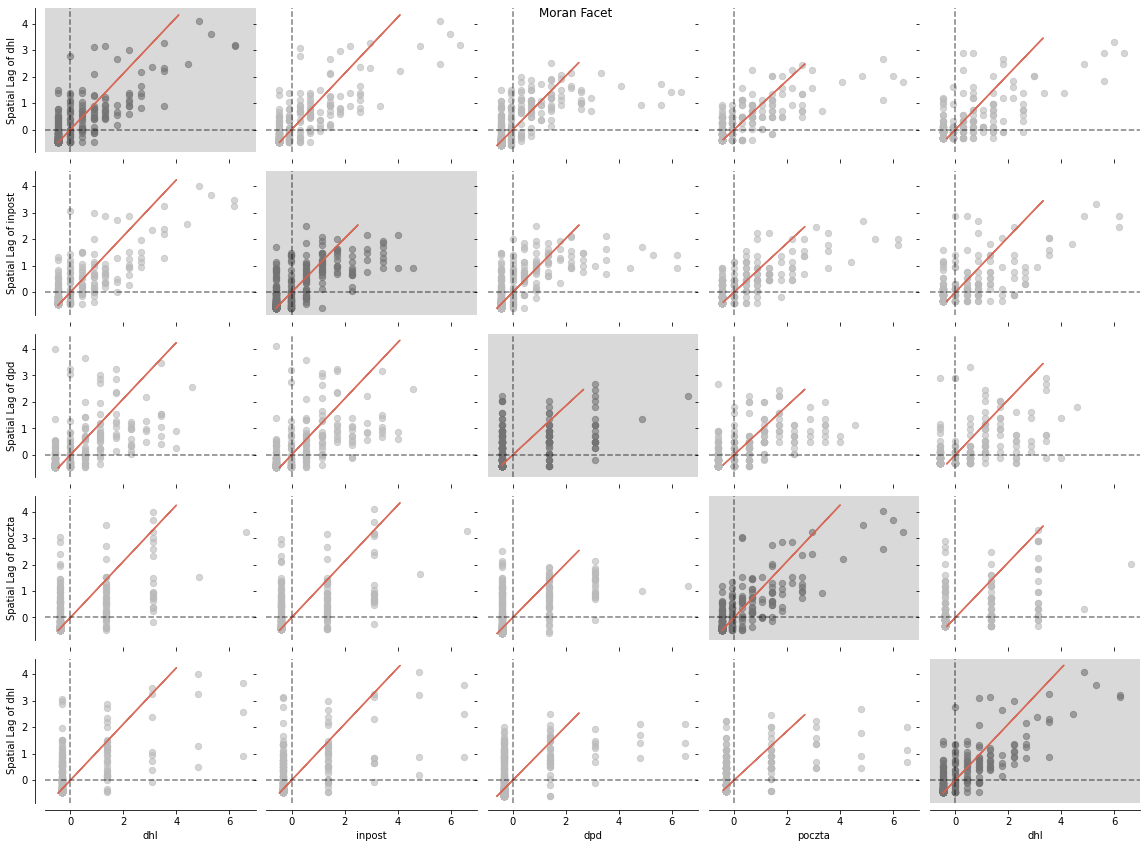

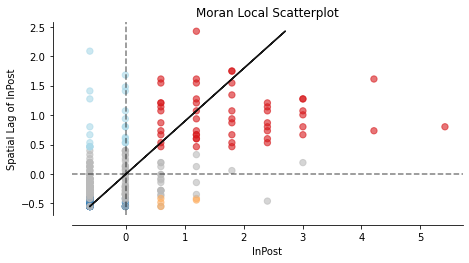

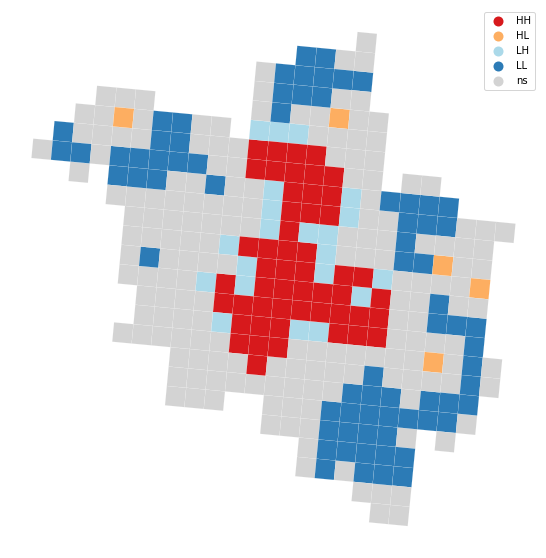

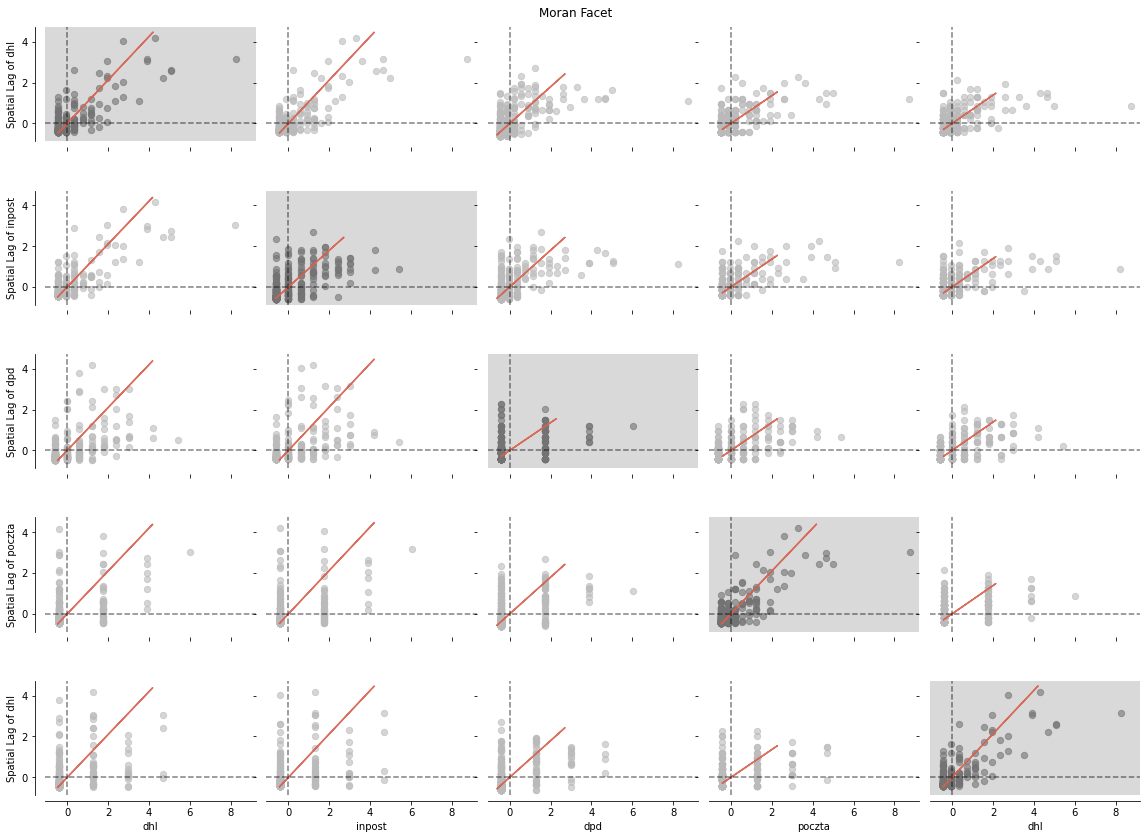

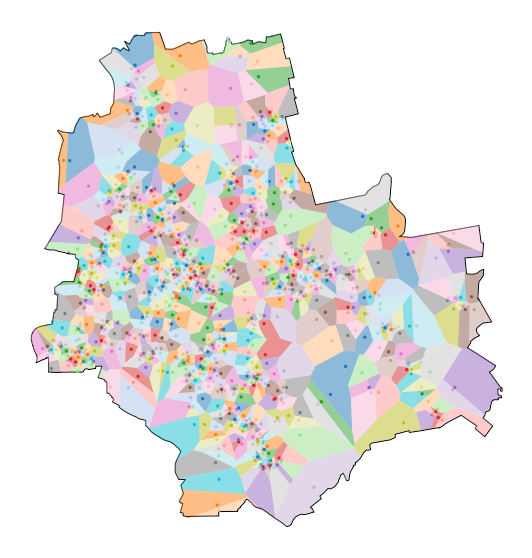

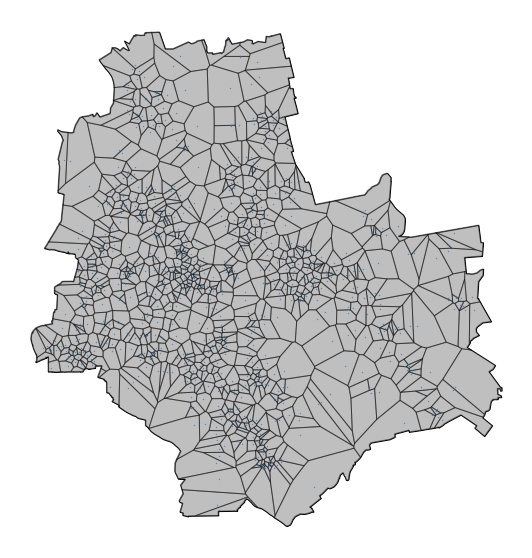

Shannon entropy  Relative H entropy
dpd            5.092312            0.900897
fedex          2.666880            0.922677
inpost         6.198246            0.905680
poczta         6.059140            0.864541
ruch           4.876571            0.870487
ups            4.381173            0.876723
dhl            5.905179            0.856863

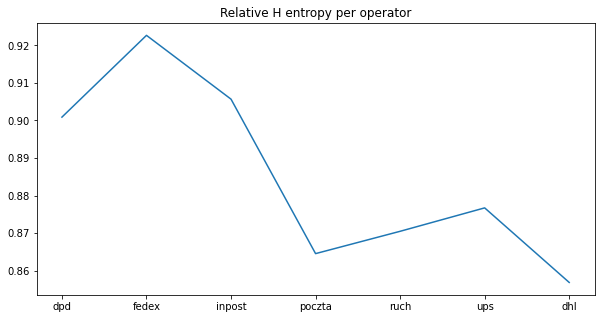

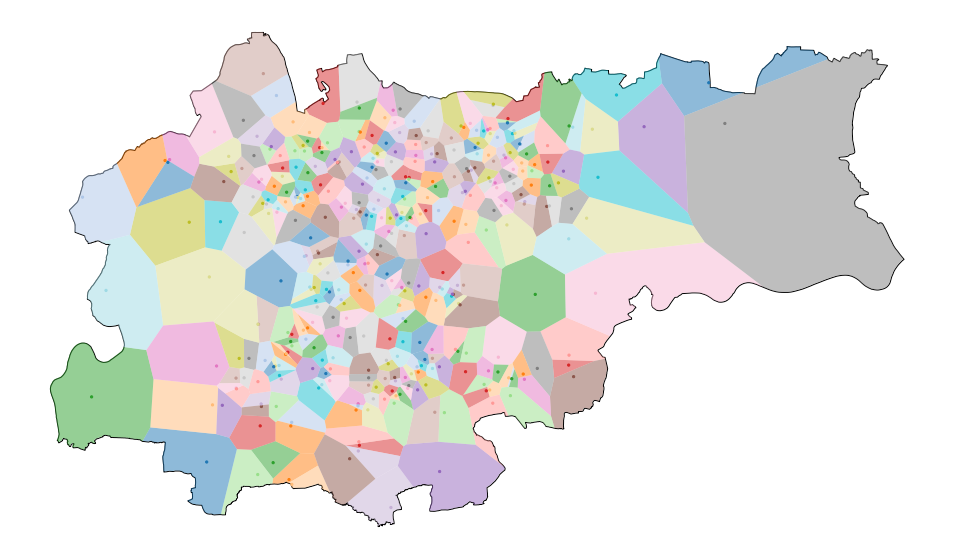

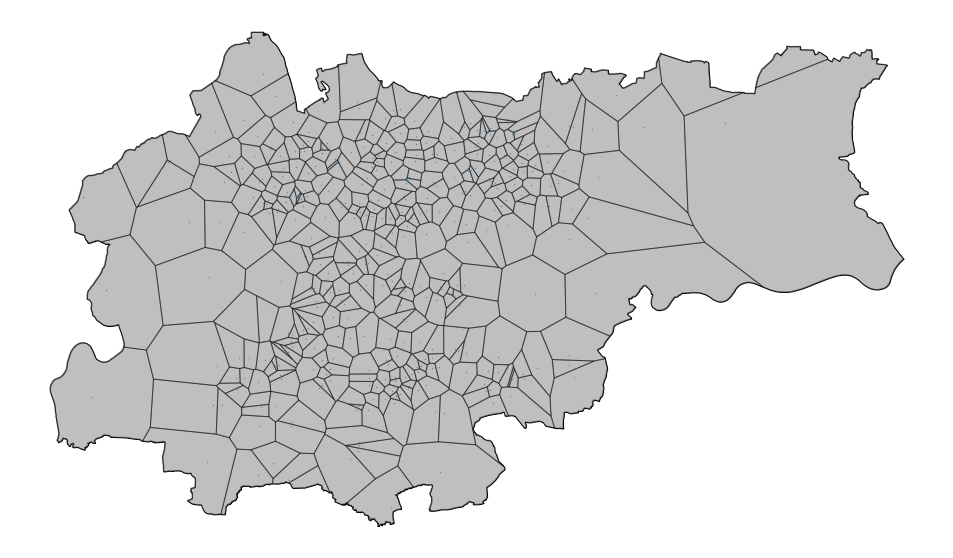

Shannon entropy  Relative H entropy
dpd            3.531301            0.784767
fedex          2.181277            0.850417
inpost         4.854113            0.814311
poczta         4.703335            0.763641
ruch           3.160325            0.741394
ups            3.216875            0.818163
dhl            4.601693            0.767403

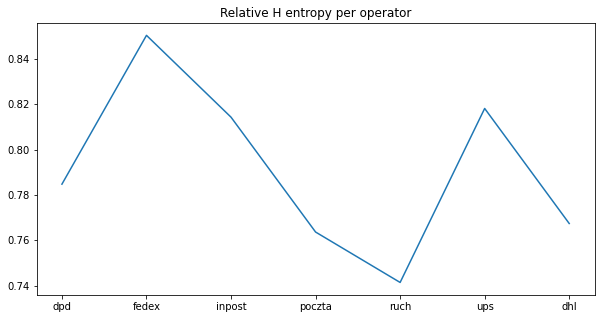

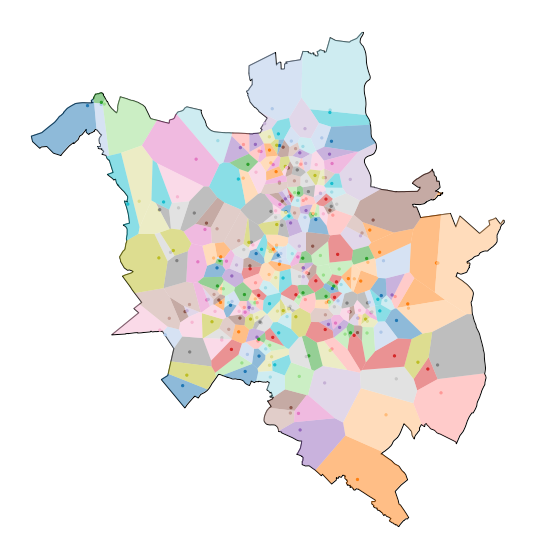

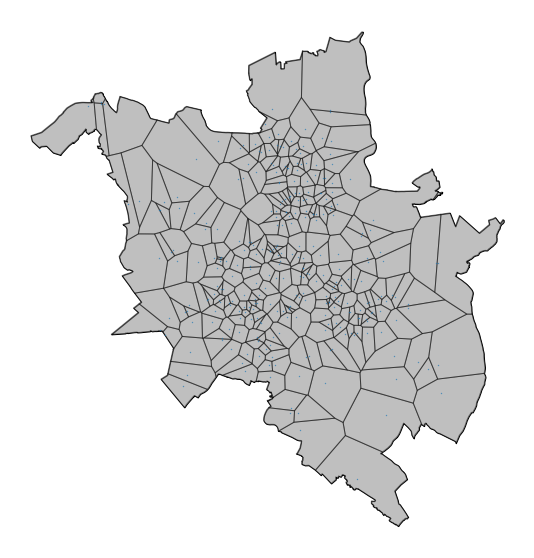

Shannon entropy  Relative H entropy
dpd            3.535085            0.874361
fedex          1.831381            0.941144
inpost         4.933869            0.866544
poczta         4.906048            0.813839
ruch           3.669732            0.858082
ups            3.042060            0.877753
dhl            4.664141            0.803035

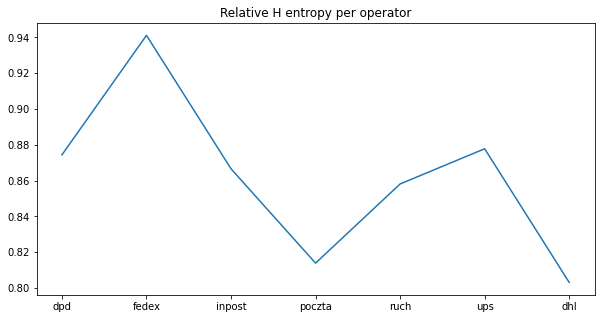

In [5]:
for i in range(1,5):
    for j,k in zip([df_warszawa, df_krakow, df_poznan], ["powiat Warszawa", "powiat Kraków", "powiat Poznań"]):
        spatial_seda(j, k, i)

In [7]:
# [df_warszawa, df_krakow, df_poznan], ["powiat Warszawa", "powiat Kraków", "powiat Poznań"]